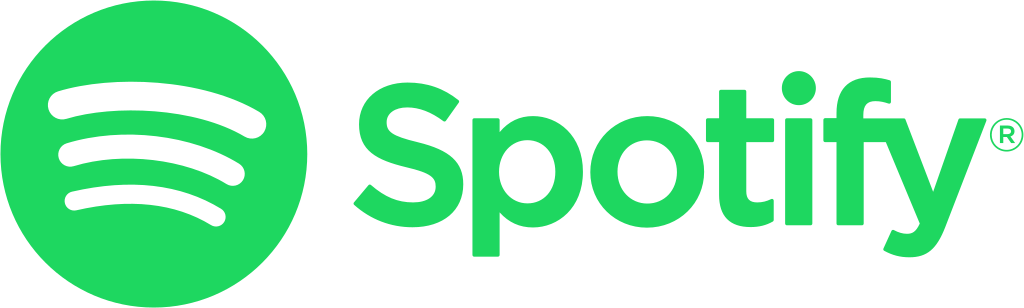

In [1]:
# Libraries used
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

In [2]:
# For label-generating model:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [3]:
# For clustering:
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [4]:
#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

Since I want to cluster my data into 4 groups, I use 4 Spotify playlists for each class. "Broken Heart" is the Sad playlist, "Mood Booster" is the Happy playlist, "Au calme" is the Calm playlist, and "Hardstyle Remixes of Popular Song" is the Energetic playlist.

Once I have obtained the songs from each playlist and their audio features, I create the dataframe, music_verify.

100 Sad songs, 85, happy songs, 100 calm songs, 70 energetic songs = 355 rows

### **EDA:**

In [5]:
# read data
mv=pd.read_csv("./data/music_verify.csv")

In [6]:
# remove columns index, and duplicated
mv.drop(columns=["Unnamed: 0","track_id","duration_ms.1"], inplace=True)

In [7]:
# Create a list with cluster labels based on the given description
cluster_labels = ['Sad'] * 100 + ['Happy'] * 85 + ['Calm'] * 100 + ['Energetic'] * 70

# Add the 'mood' column to the DataFrame mv
mv['mood'] = cluster_labels

In [8]:
mv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            355 non-null    object 
 1   album             355 non-null    object 
 2   song_name         355 non-null    object 
 3   release_date      355 non-null    object 
 4   duration_ms       355 non-null    int64  
 5   popularity        355 non-null    int64  
 6   danceability      355 non-null    float64
 7   energy            355 non-null    float64
 8   key               355 non-null    int64  
 9   loudness          355 non-null    float64
 10  mode              355 non-null    int64  
 11  speechiness       355 non-null    float64
 12  acousticness      355 non-null    float64
 13  instrumentalness  355 non-null    float64
 14  liveness          355 non-null    float64
 15  valence           355 non-null    float64
 16  tempo             355 non-null    float64
 1

Everything is fine. There are no missing data

In [9]:
mv.describe()

duration_ms  popularity  danceability      energy         key  \
count     355.000000  355.000000    355.000000  355.000000  355.000000   
mean   207209.952113   66.994366      0.561200    0.565860    5.185915   
std     45419.643804   14.341476      0.148451    0.259106    3.596817   
min    108705.000000    0.000000      0.188000    0.056500    0.000000   
25%    173259.000000   56.000000      0.450000    0.343000    2.000000   
50%    202414.000000   68.000000      0.561000    0.574000    5.000000   
75%    238487.500000   78.000000      0.668500    0.799000    9.000000   
max    370666.000000   96.000000      0.943000    0.998000   11.000000   

         loudness        mode  speechiness  acousticness  instrumentalness  \
count  355.000000  355.000000   355.000000    355.000000        355.000000   
mean    -7.615099    0.650704     0.060906      0.399545          0.041656   
std      3.984208    0.477420     0.051030      0.353112          0.143374   
min    -22.320000    0.000000     0.024200      0.000074          0.000000   
25%    -10.061500    0.000000     0.033850      0.048950          0.000000   
50%     -6.678000    1.000000     0.042000      0.307000          0.000016   
75%     -4.745500    1.000000     0.064350      0.755500          0.001355   
max      0.691000    1.000000     0.367000      0.988000          0.962000   

         liveness     valence       tempo  time_signature  
count  355.000000  355.000000  355.000000      355.000000  
mean     0.170081    0.395474  124.337915        3.904225  
std      0.134736    0.228471   30.966880        0.393247  
min      0.023200    0.035000   67.513000        1.000000  
25%      0.098600    0.205500   99.887000        4.000000  
50%      0.118000    0.352000  122.035000        4.000000  
75%      0.191500    0.555500  149.961500        4.000000  
max      0.972000    0.960000  208.282000        5.000000

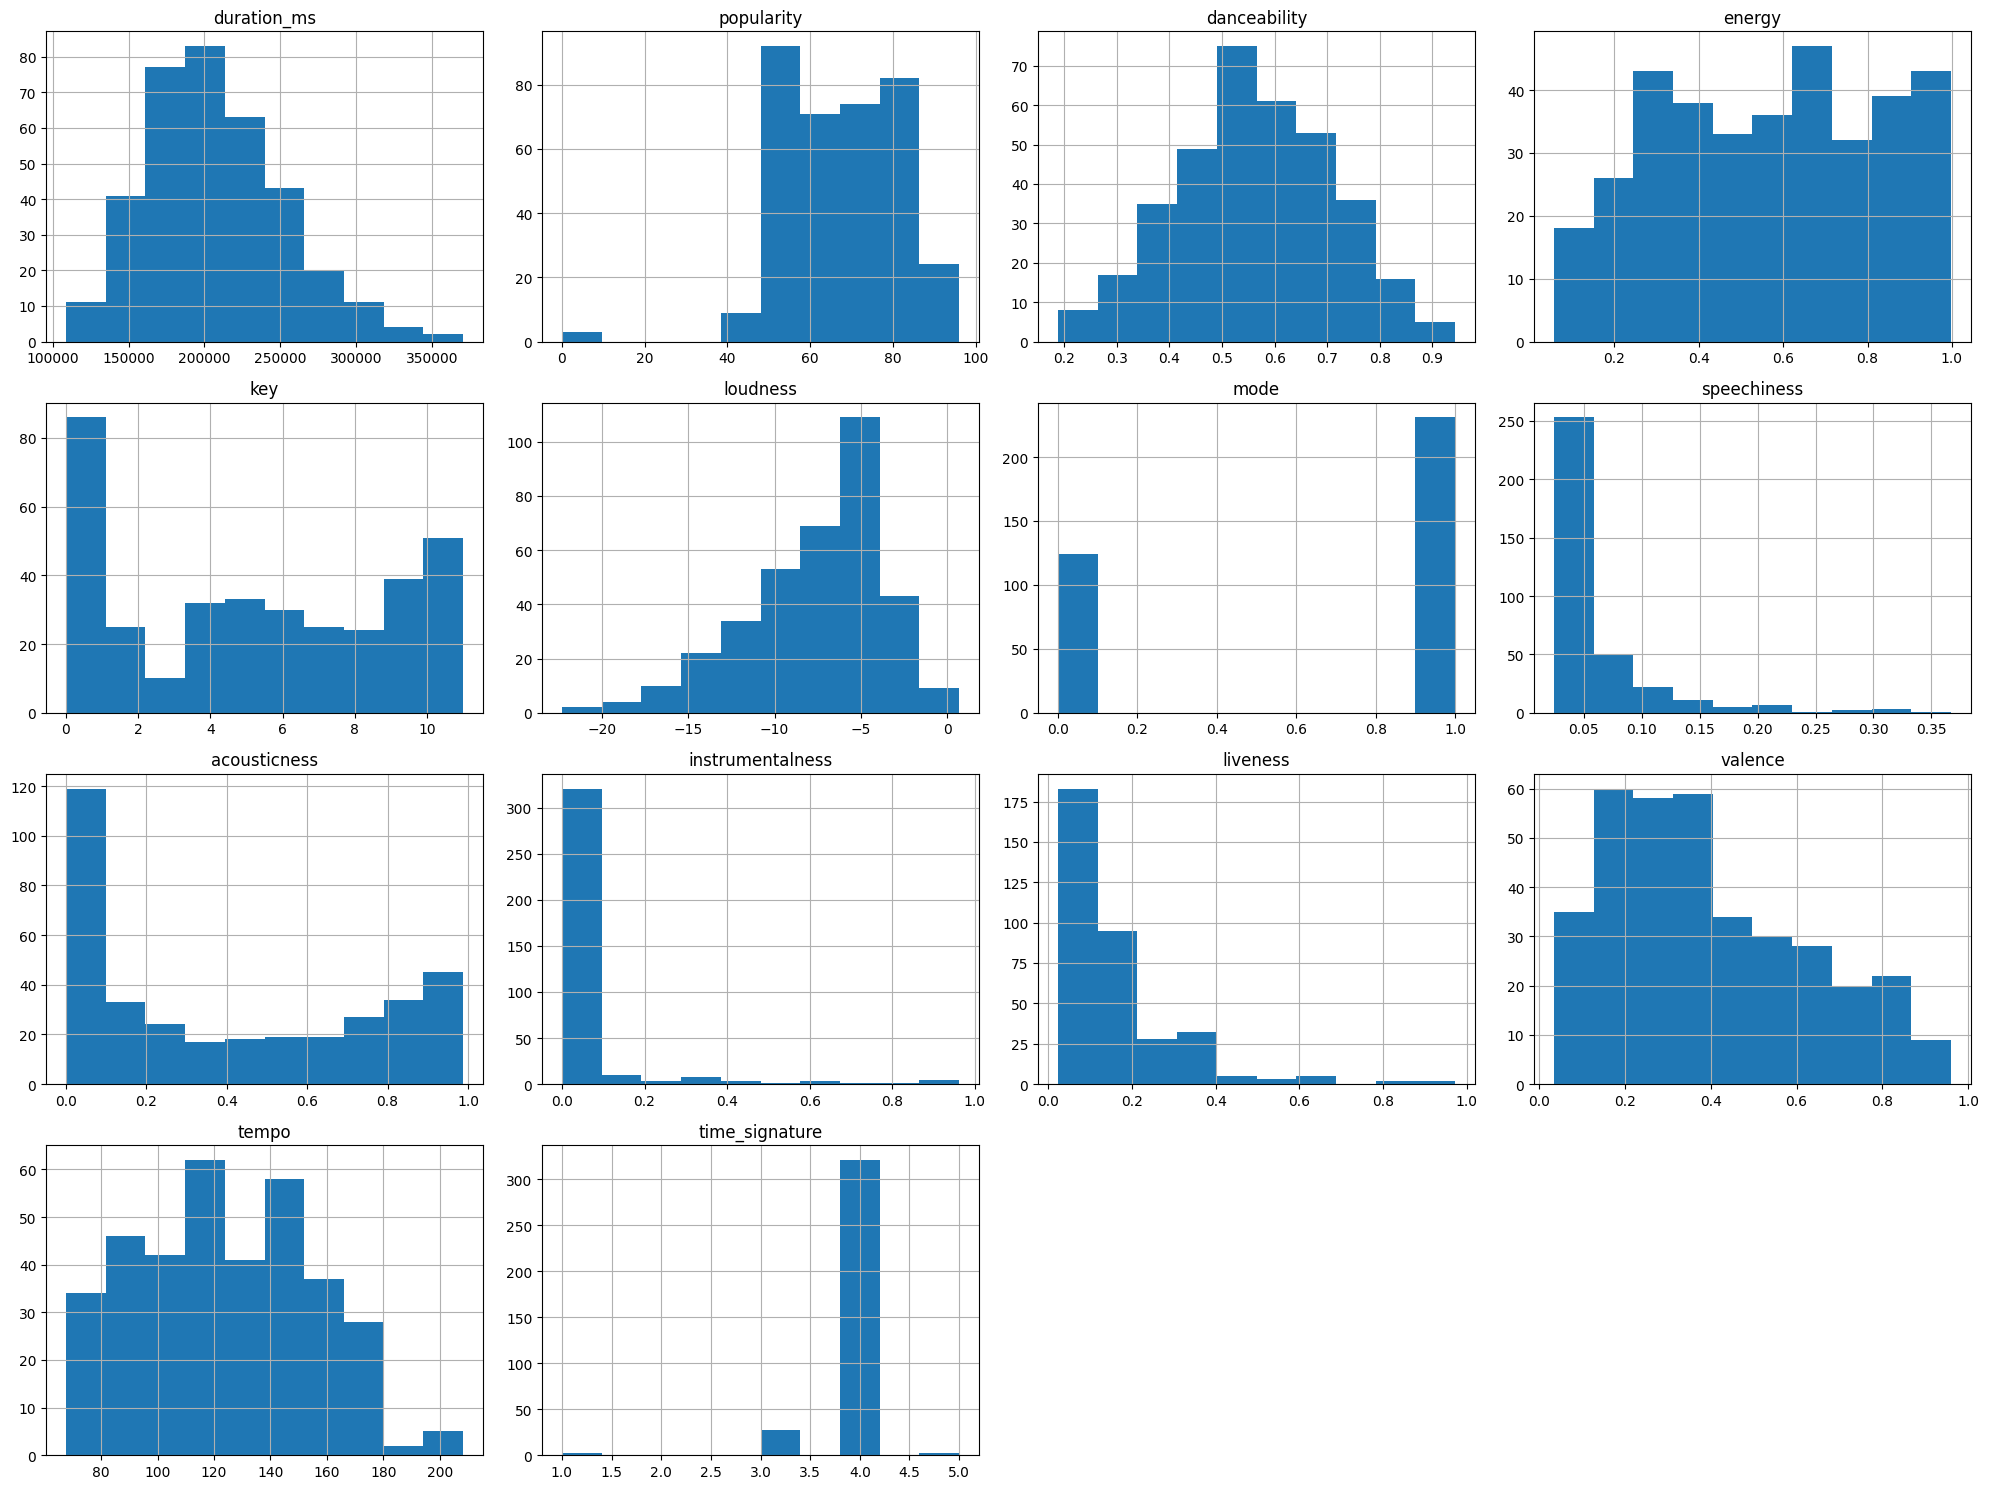

In [10]:
# Plot histograms for each column
mv.hist(figsize=(20, 15))
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

We can observe that tempo, key, duration_ms, loudness and popularity features are not on the same scale, so we will rescaling the data in the next section.

#### Columns:


1. Name: The name of the music track.

2. Album: The name of the album to which the music track belongs.

3. Artist: The name of the artist or band who performed the music track.

4. ID: A unique identifier for the music track, often used internally by Spotify or other music platforms.

5. Release Date: The date when the music track was released

6. popularity: represents the popularity score of a track or an artist on Spotify. This score is calculated by Spotify based on factors like the number of streams, recent streams, and other engagement metrics. It provides an indication of how popular a track or artist is relative to others.

1. danceability: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm
stability, beat strength, and overall regularity. Values range from 0 to 1, where 0 is least danceable and 1 is most danceable.

7. acousticness: A measure of the confidence that a track is acoustic. Values range from 0 to 1, where 1 represents high confidence that the track is acoustic.

2. energy: Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. Values range from 0 to 1, where 0 is least energetic and 1 is most energetic.

3. key: The key the track is in, encoded as integers in pitch class notation (0 = C, 1 = C♯/D♭, 2 = D, and so on).

4. loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

5. mode: Modality indicates the modality of a track (major or minor), represented as either 0 (minor) or 1 (major).

6. speechiness: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g., talk show, audio book, poetry), the higher the value. Values range from 0 to 1.

8. instrumentalness: Predicts whether a track contains no vocals. Values range from 0 to 1, where 1 represents high confidence that the track is instrumental.

9. liveness: Detects the presence of an audience in the recording. Values above 0.8 provide a strong likelihood that the track is live.

10. valence: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g., sad, depressed, angry). Values range from 0 to 1.

11. tempo: The overall estimated tempo of a track in beats per minute (BPM).

13. duration_ms: The duration of the track in milliseconds.

14. time_signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar and which note value constitutes one beat.

16. Mood: This column likely contains labels or categories indicating the mood or emotional tone of the music track, which could be assigned manually or derived from other features in the dataset.

#### Feature Selection:

In [11]:
# average values
sad_values = mv[mv["mood"]=="Sad"].describe().loc["mean"]
happy_values = mv[mv["mood"]=="Happy"].describe().loc["mean"]
calm_values = mv[mv["mood"]=="Calm"].describe().loc["mean"]
energetic_values = mv[mv["mood"]=="Energetic"].describe().loc["mean"]

In [12]:
moods_values=pd.DataFrame({"Sad":sad_values, "Happy": happy_values,"Calm":calm_values, "Energetic":energetic_values}).T
moods_values

duration_ms  popularity  danceability    energy       key  \
Sad        224940.820000   75.600000      0.498130  0.417492  4.960000   
Happy      186892.552941   75.976471      0.696953  0.710412  5.411765   
Calm       227620.480000   59.540000      0.563740  0.354041  5.030000   
Energetic  177393.371429   54.442857      0.482829  0.904886  5.457143   

            loudness      mode  speechiness  acousticness  instrumentalness  \
Sad        -8.686870  0.710000     0.047909      0.573816          0.008194   
Happy      -5.465600  0.658824     0.061856      0.144905          0.001829   
Calm      -11.264050  0.650000     0.046936      0.685255          0.092995   
Energetic  -3.481314  0.557143     0.098277      0.051636          0.064480   

           liveness   valence       tempo  time_signature  
Sad        0.129124  0.260194  117.117090        3.940000  
Happy      0.168113  0.610459  120.202059        3.941176  
Calm       0.135858  0.365553  115.646480        3.830000  
Energetic  0.279871  0.370423  152.091829        3.914286

##### Option 1:

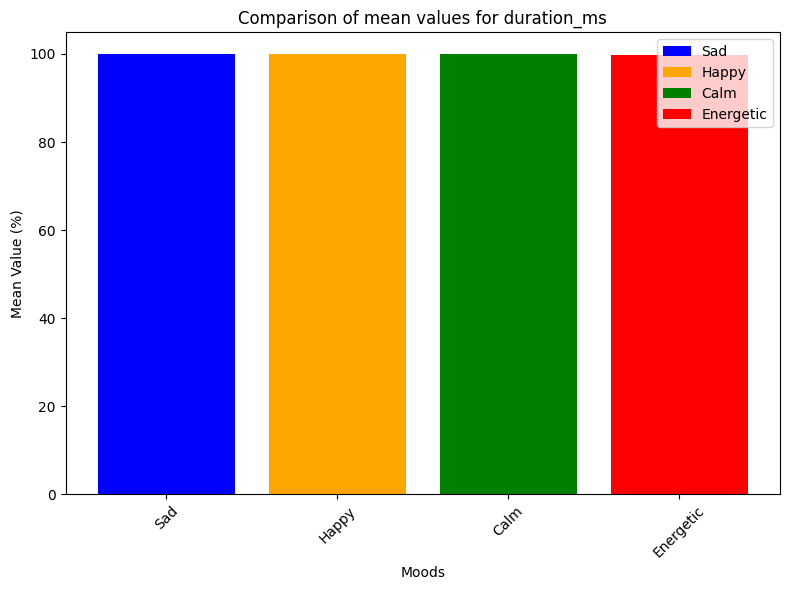

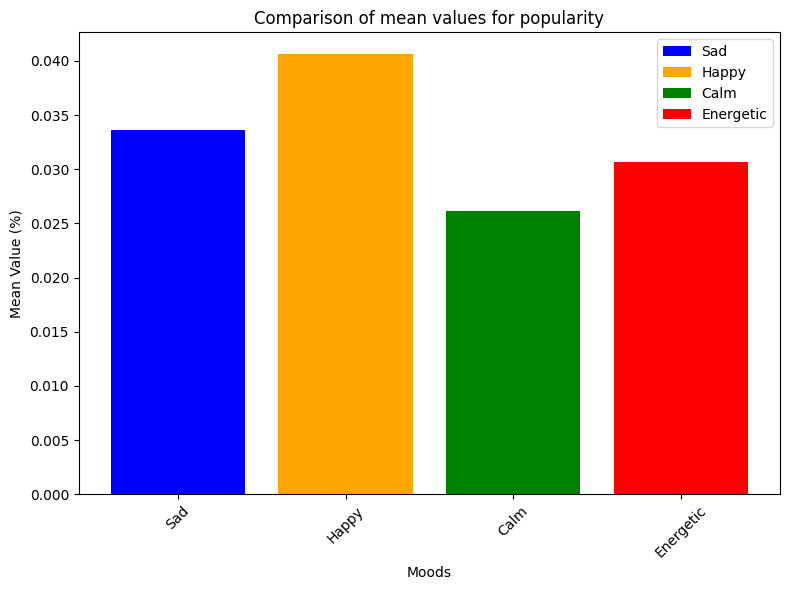

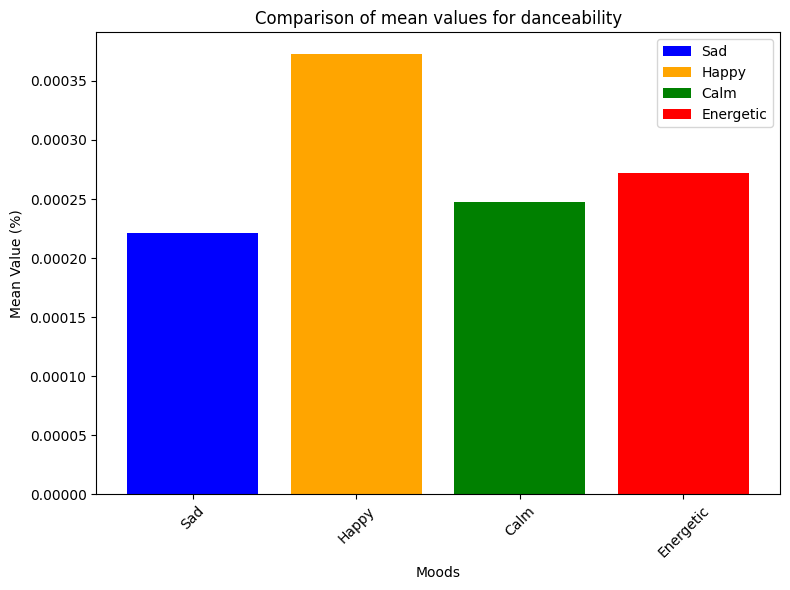

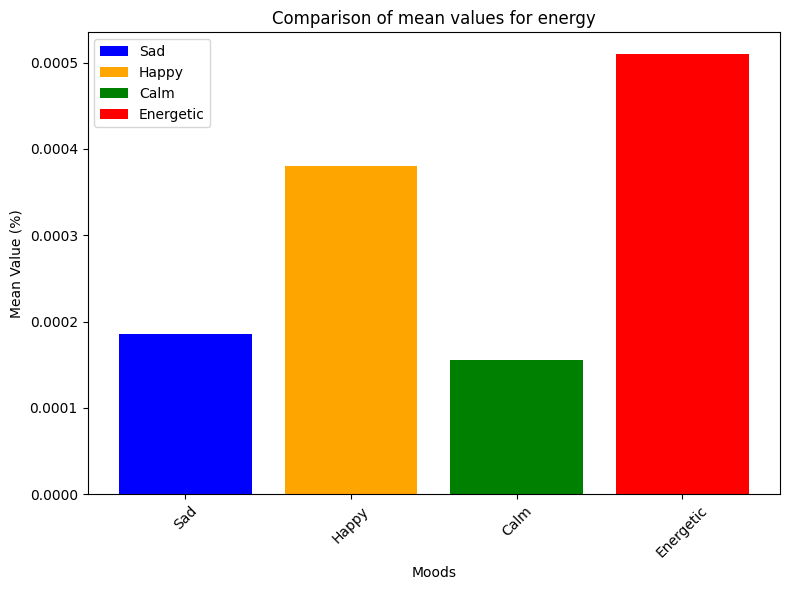

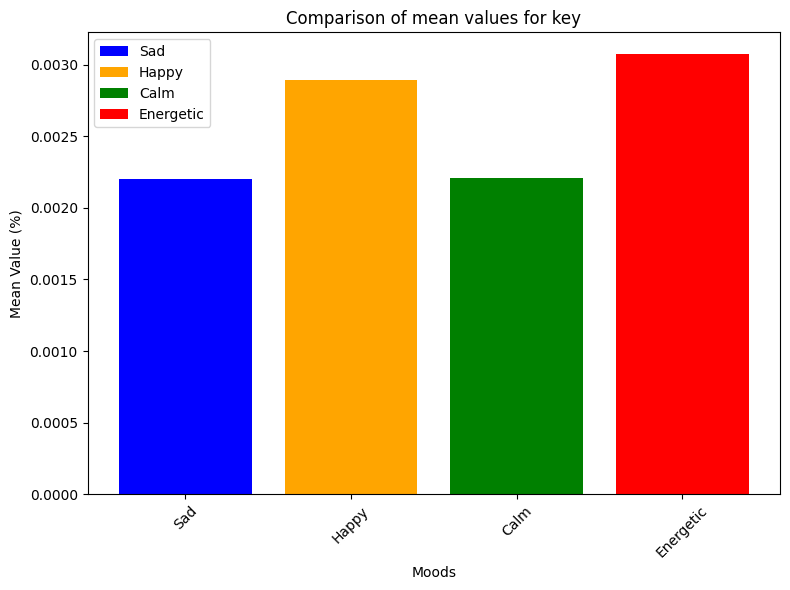

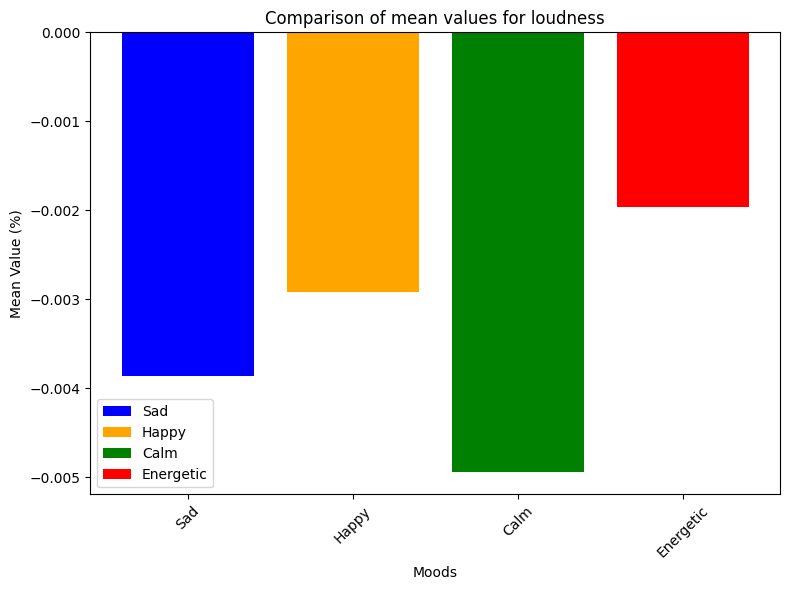

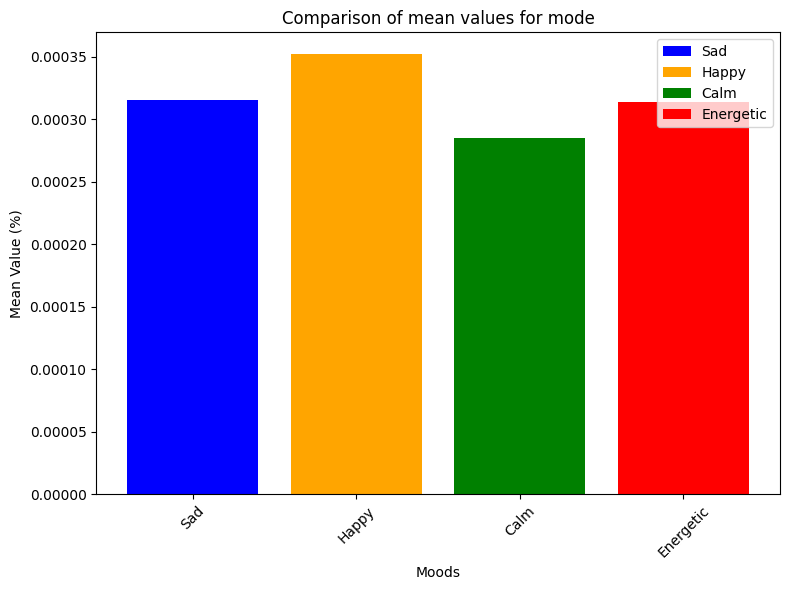

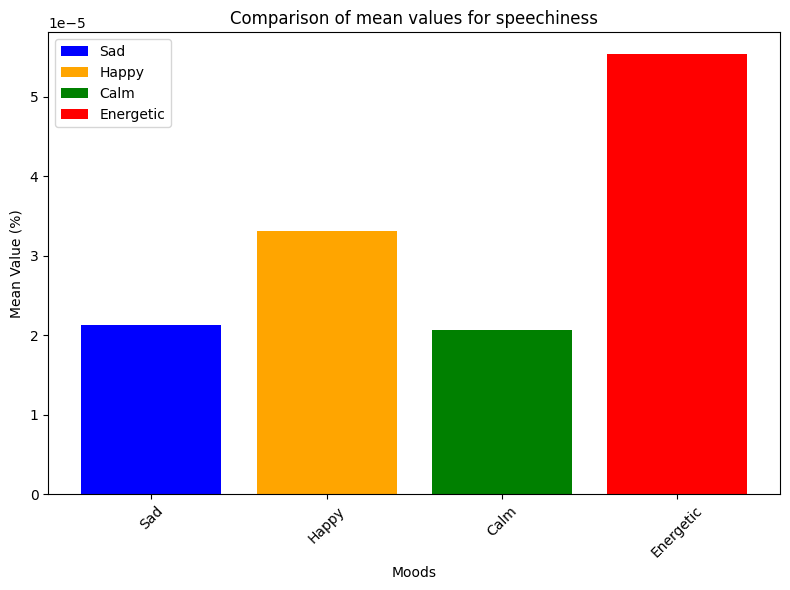

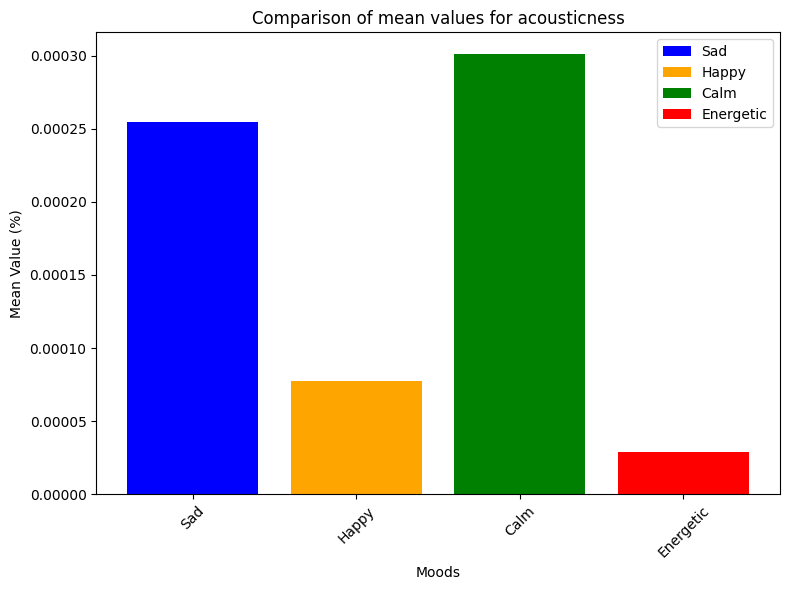

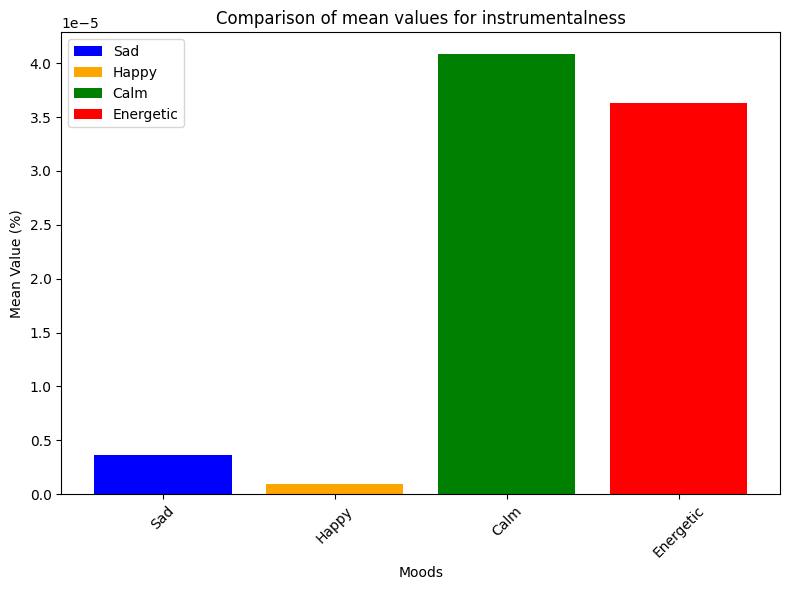

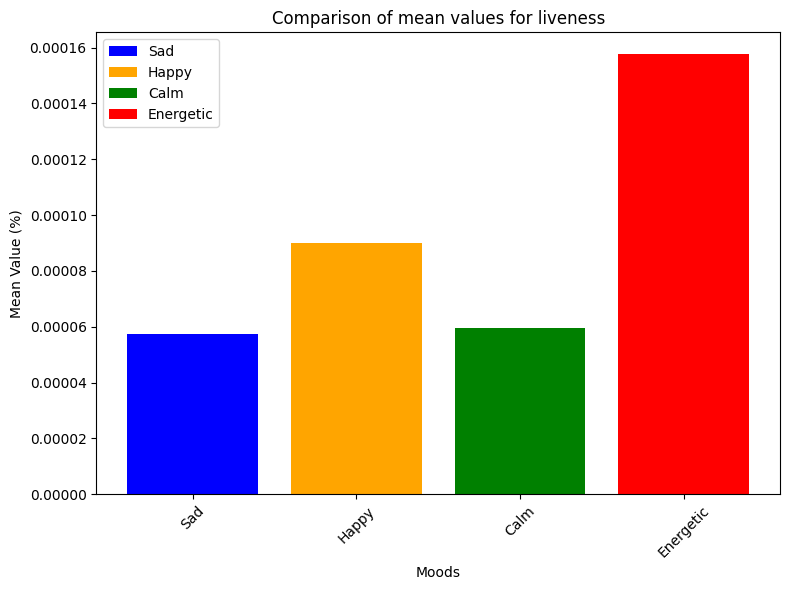

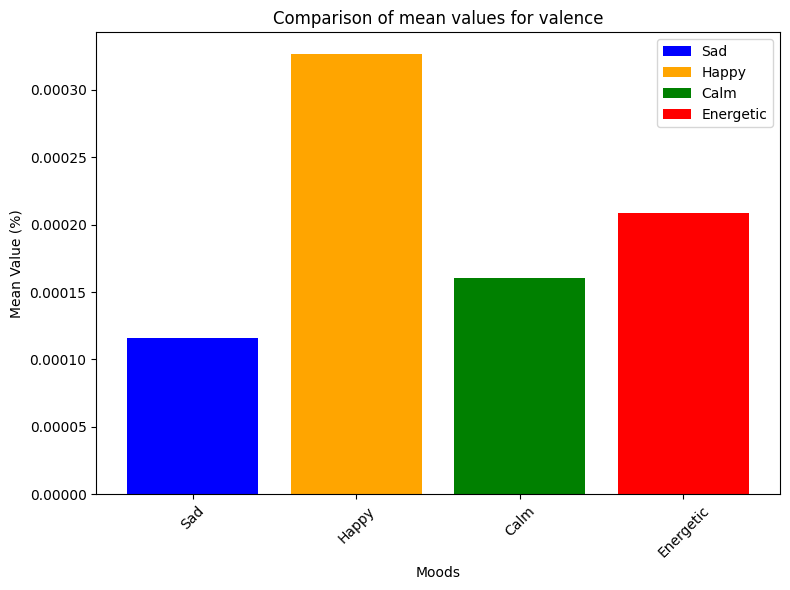

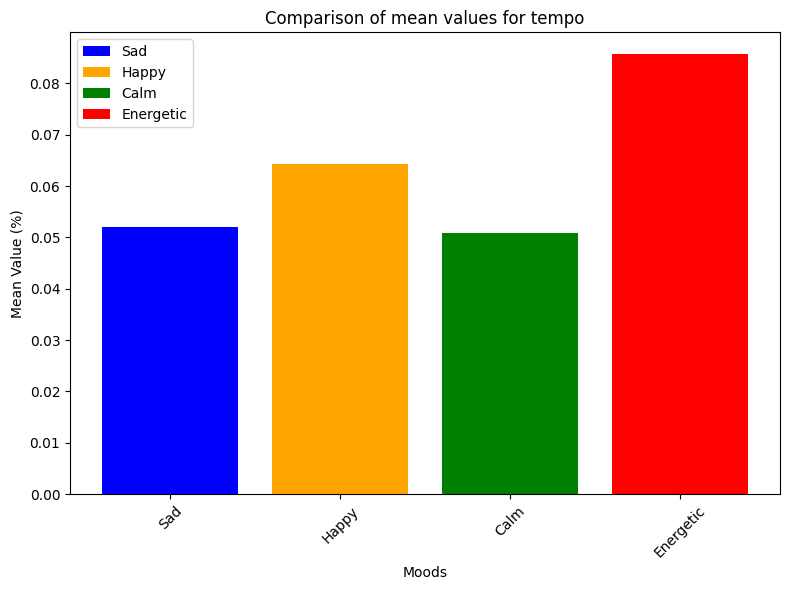

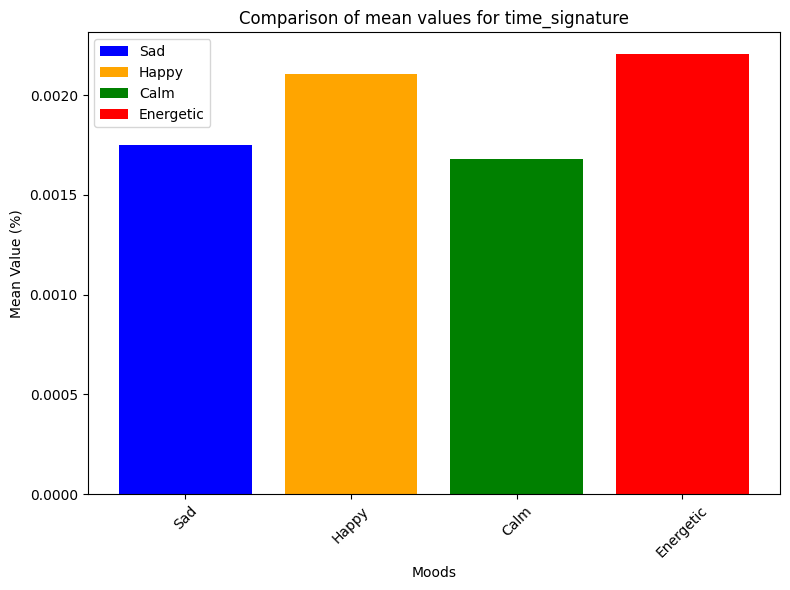

In [13]:
# Define colors for each mood
colors = {'Sad': 'blue', 'Happy': 'orange', 'Calm': 'green', 'Energetic': 'red'}

# Iterate over each column (feature) of the DataFrame
for column in moods_values:
    # Create a bar plot to compare mean values for each mood and feature
    plt.figure(figsize=(8, 6))
    for mood in moods_values.index:
        # Convert mean values to percentages
        total = moods_values.loc[mood].sum()
        percent_values = (moods_values.loc[mood, column] / total) * 100
        plt.bar(mood, percent_values, color=colors[mood], label=mood)

    plt.xlabel('Moods')
    plt.ylabel('Mean Value (%)')  # Update ylabel to indicate percentage
    plt.title(f'Comparison of mean values for {column}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

For the feature selection, I choose the ones that are most representative: danceability, acousticness, energy, instrumentalness, liveness, valence, loudness, speechiness, and tempo.

In [14]:
# Feature columns
col_features = ['danceability',
                'acousticness',
                'energy',
                'instrumentalness',
                'liveness',
                'valence',
                'loudness',
                'speechiness',
                'tempo']


##### Option 2:

In [15]:
# target
y = mv['mood']

# Scaling data
scaler = MinMaxScaler()
X = scaler.fit_transform(mv[col_features])

# Encode categories
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

In [16]:
# Train/Test
X_train, X_val, y_train, y_val = train_test_split(X,encoded_y, test_size=0.2, random_state=42)

In [17]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get the coefficients (weights) of the model
feature_weights = model.coef_[0]

# Create a dictionary with features and their weights
feature_weights_dict = {feature: weight for feature, weight in zip(col_features, feature_weights)}

# Sort the features by their weights in descending order
sorted_features = sorted(feature_weights_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top features, for example, the 5 with the highest absolute weights
top_features = [feature[0] for feature in sorted_features[:5]]

print("Top features based on weights:", top_features)

Top features based on weights: ['loudness', 'energy', 'acousticness', 'instrumentalness', 'tempo']


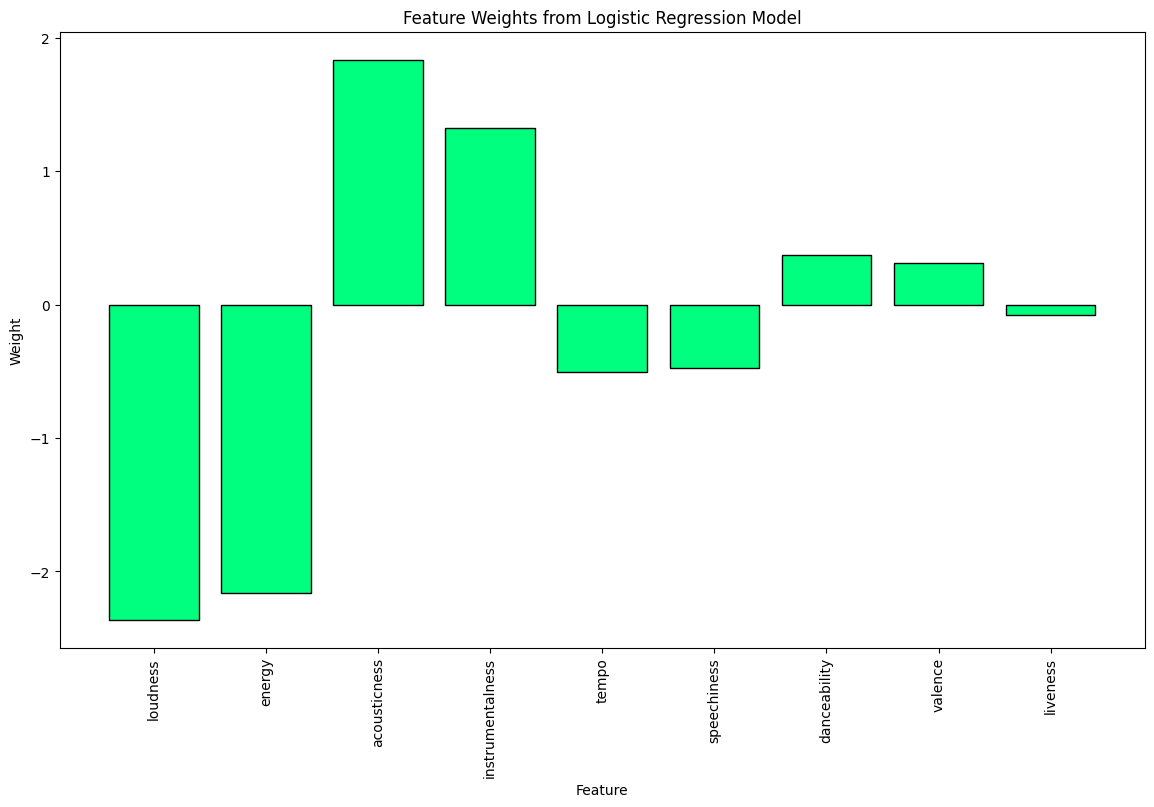

In [18]:
# Extract feature names and weights for all features
feature_names = [feature[0] for feature in sorted_features]
weights = [feature[1] for feature in sorted_features]

# Create a bar plot
plt.figure(figsize=(14, 8))
plt.bar(feature_names, weights, color='springgreen', edgecolor='black')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Feature Weights from Logistic Regression Model')
plt.xticks(rotation=90)
plt.show()

### **CLUSTERING:**

In [19]:
# log1p for liveness and instrumentalness
mv['instrumentalness'] = np.log1p(mv['instrumentalness'])
mv['liveness'] = np.log1p(mv['liveness'])

# Normalize features to the range [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(mv[col_features])

# Perform clustering with KMeans
kmeans = KMeans(init="k-means++",
                n_clusters=4,
                max_iter=1000,
                random_state=42).fit(X)

# Add cluster labels to the DataFrame
mv['cluster_1'] = kmeans.labels_

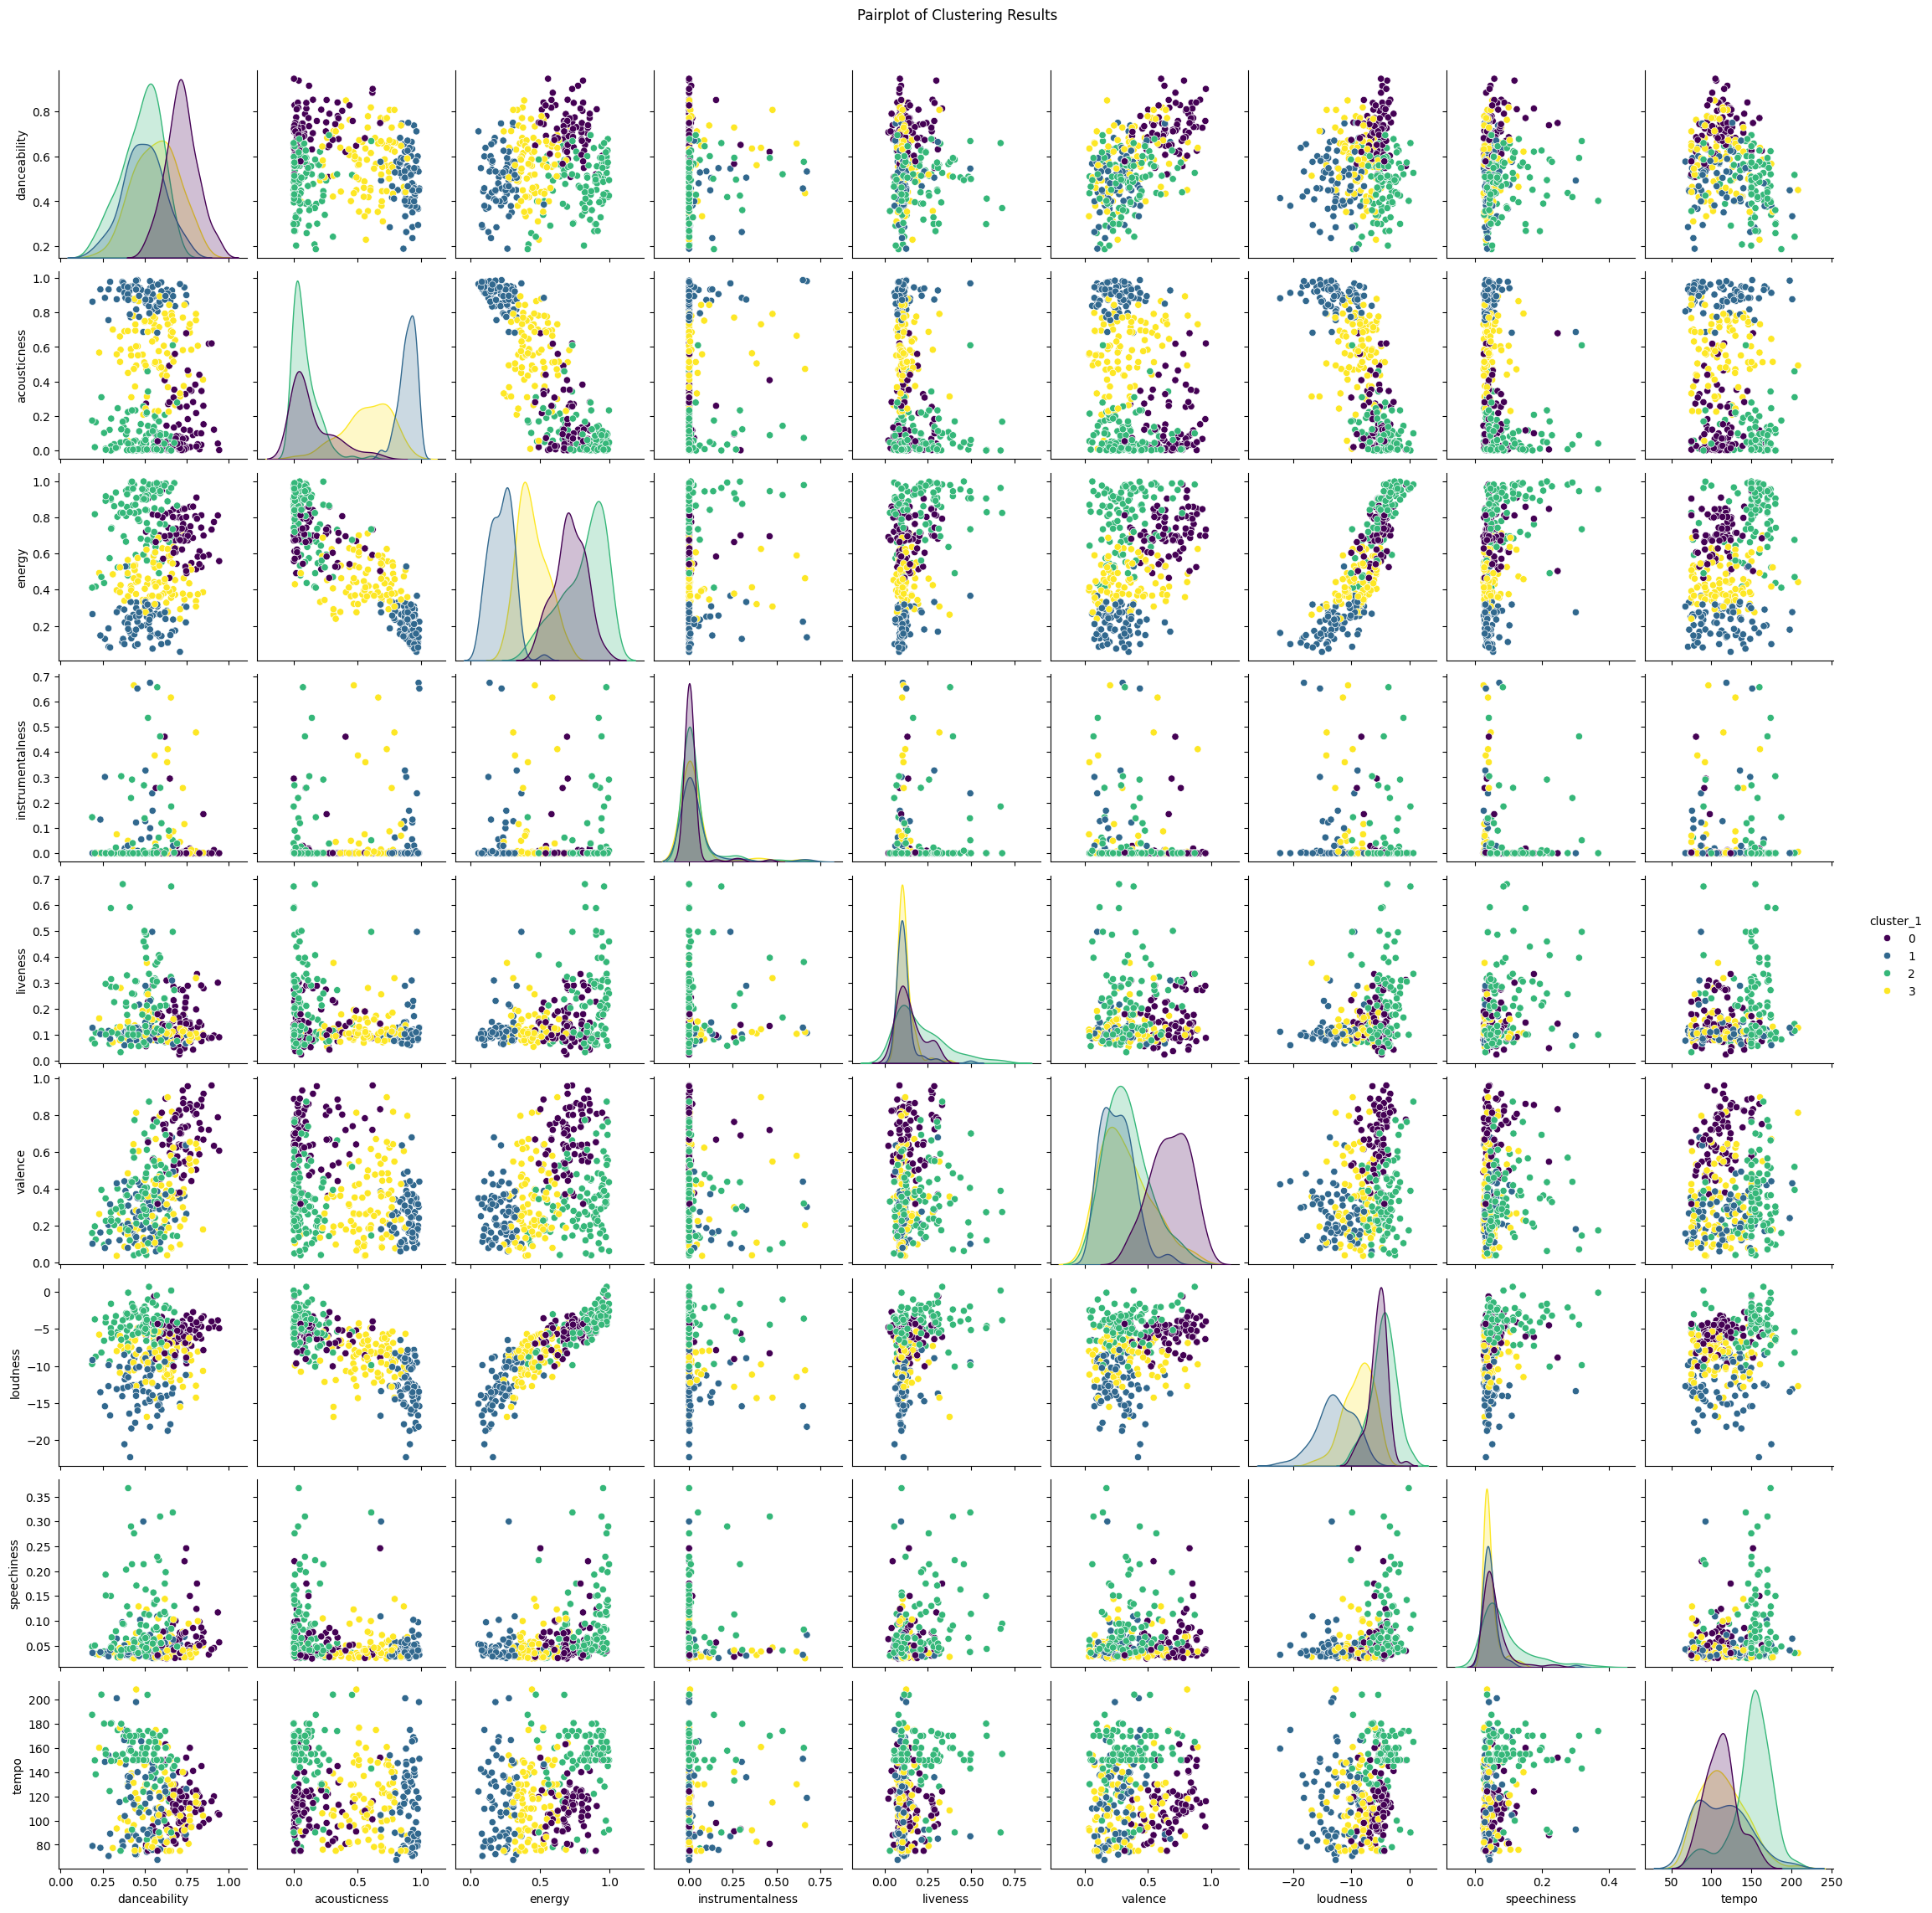

In [20]:
# Pairplot to visualize all combinations of features
sns.pairplot(mv, vars=col_features, hue='cluster_1', palette='viridis')
plt.suptitle('Pairplot of Clustering Results', y=1.02)
plt.show()

Lets try option 2

In [21]:
# log1p for liveness and instrumentalness
mv['instrumentalness'] = np.log1p(mv['instrumentalness'])
mv['liveness'] = np.log1p(mv['liveness'])

# Normalize features to the range [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(mv[top_features])

# Perform clustering with KMeans
kmeans = KMeans(init="k-means++",
                n_clusters=4,
                max_iter=1000,
                random_state=42).fit(X)

# Add cluster labels to the DataFrame
mv['cluster_2'] = kmeans.labels_

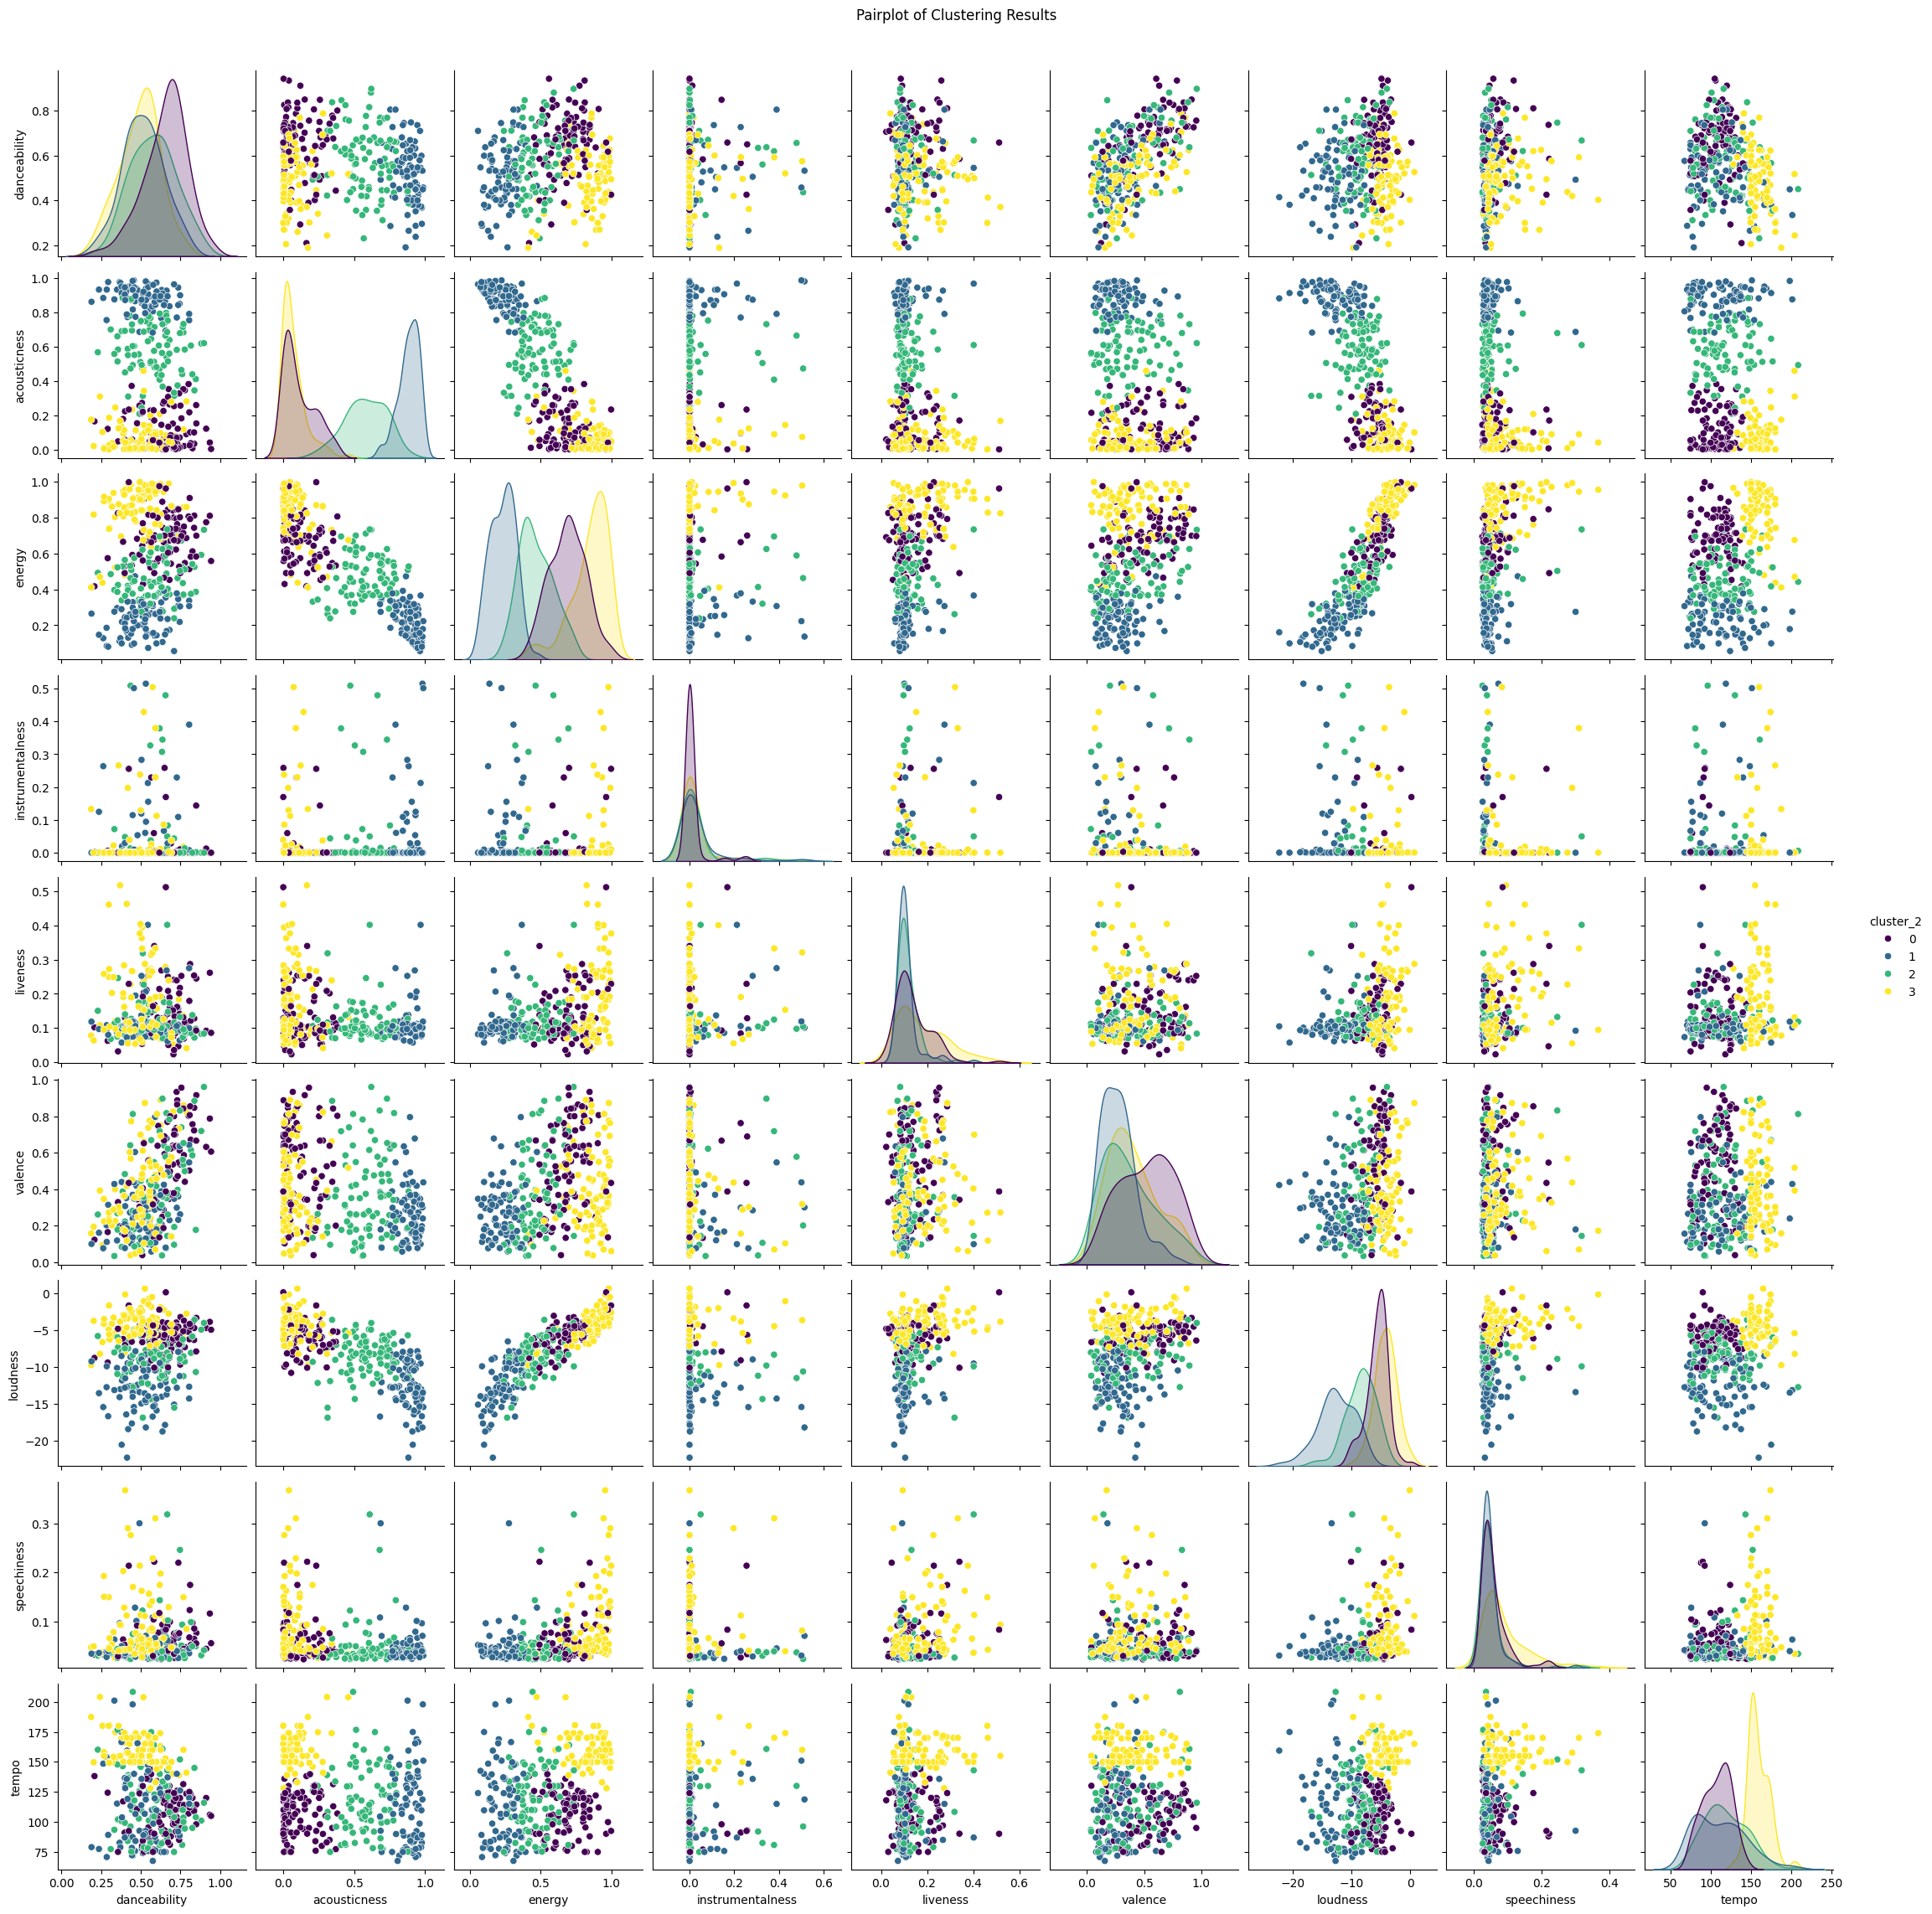

In [22]:
# Pairplot to visualize all combinations of features
sns.pairplot(mv, vars=col_features, hue='cluster_2', palette='viridis')
plt.suptitle('Pairplot of Clustering Results', y=1.02)
plt.show()

In [23]:
# average values cluster_1
cluster_1_0_mean = mv[mv["cluster_1"] == 0].describe().loc["mean"]
cluster_1_1_mean = mv[mv["cluster_1"] == 1].describe().loc["mean"]
cluster_1_2_mean = mv[mv["cluster_1"] == 2].describe().loc["mean"]
cluster_1_3_mean = mv[mv["cluster_1"] == 3].describe().loc["mean"]

cluster_1_values = pd.DataFrame({"cluster_1_0": cluster_1_0_mean, "cluster_1_1": cluster_1_1_mean, "cluster_1_2": cluster_1_2_mean, "cluster_1_3": cluster_1_3_mean})
cluster_1_values

cluster_1_0    cluster_1_1    cluster_1_2    cluster_1_3
duration_ms       189850.573171  231310.051948  192875.380952  218999.967033
popularity            70.487805      66.610390      62.228571      69.670330
danceability           0.719159       0.493987       0.480057       0.569363
energy                 0.714610       0.219056       0.808552       0.445242
key                    5.390244       4.805195       5.333333       5.153846
loudness              -5.440390     -12.784351      -4.527619      -8.763220
mode                   0.646341       0.649351       0.533333       0.791209
speechiness            0.057120       0.046094       0.089009       0.044426
acousticness           0.143512       0.893494       0.087128       0.572780
instrumentalness       0.013437       0.034039       0.032620       0.034326
liveness               0.134278       0.109291       0.183001       0.112047
valence                0.675280       0.257557       0.336328       0.328286
tempo                112.340573     113.902766     150.137752     114.209407
time_signature         3.926829       3.792208       3.952381       3.923077
cluster_1              0.000000       1.000000       2.000000       3.000000
cluster_2              0.548780       1.012987       2.361905       1.725275

In [25]:
# average values cluster_2
cluster_2_0_mean = mv[mv["cluster_2"] == 0].describe().loc["mean"]
cluster_2_1_mean = mv[mv["cluster_2"] == 1].describe().loc["mean"]
cluster_2_2_mean = mv[mv["cluster_2"] == 2].describe().loc["mean"]
cluster_2_3_mean = mv[mv["cluster_2"] == 3].describe().loc["mean"]

cluster_2_values = pd.DataFrame({"cluster_2_0": cluster_2_0_mean, "cluster_2_1": cluster_2_1_mean, "cluster_2_2": cluster_2_2_mean, "cluster_2_3": cluster_2_3_mean})
cluster_2_values

cluster_2_0    cluster_2_1    cluster_2_2    cluster_2_3
duration_ms       204192.223404  227815.305882  216445.141176  182454.131868
popularity            70.500000      66.047059      69.976471      61.472527
danceability           0.654309       0.514235       0.578588       0.492648
energy                 0.687989       0.230756       0.467471       0.844615
key                    5.031915       5.000000       4.941176       5.747253
loudness              -5.637840     -12.620824      -8.433059      -4.217835
mode                   0.595745       0.658824       0.811765       0.549451
speechiness            0.056678       0.046836       0.048662       0.089853
acousticness           0.113476       0.884024       0.580435       0.073547
instrumentalness       0.012749       0.040239       0.032396       0.031858
liveness               0.138495       0.110483       0.117152       0.180990
valence                0.520433       0.275996       0.370167       0.401634
tempo                107.506457     111.522000     118.515741     159.133462
time_signature         3.936170       3.811765       3.917647       3.945055
cluster_1              0.723404       1.211765       2.647059       1.802198
cluster_2              0.000000       1.000000       2.000000       3.000000

In [26]:
mv["cluster_1"][mv["mood"]=="Sad"].value_counts()

cluster_1
3    43
1    33
2    18
0     6
Name: count, dtype: int64

In [27]:
mv["cluster_1"][mv["mood"]=="Happy"].value_counts()

cluster_1
0    62
2    16
3     7
Name: count, dtype: int64

In [28]:
mv["cluster_1"][mv["mood"]=="Calm"].value_counts()

cluster_1
1    44
3    41
0    10
2     5
Name: count, dtype: int64

In [29]:
mv["cluster_1"][mv["mood"]=="Energetic"].value_counts()

cluster_1
2    66
0     4
Name: count, dtype: int64

For this case:
- Calm, macthes with cluster 1
- Energetic, matches with cluster 2
- Happy with cluster 0
- Sad with cluster 3

The model confuses 'Calm' and 'Sad'.

In [30]:
mv["cluster_2"][mv["mood"]=="Sad"].value_counts()

cluster_2
1    36
2    35
0    23
3     6
Name: count, dtype: int64

In [31]:
mv["cluster_2"][mv["mood"]=="Happy"].value_counts()

cluster_2
0    57
3    18
2    10
Name: count, dtype: int64

In [32]:
mv["cluster_2"][mv["mood"]=="Calm"].value_counts()

cluster_2
1    49
2    40
0     9
3     2
Name: count, dtype: int64

In [33]:
mv["cluster_2"][mv["mood"]=="Energetic"].value_counts()

cluster_2
3    65
0     5
Name: count, dtype: int64

For this case, cluster_2:
- Calm, macthes with cluster 1
- Energetic, matches with cluster 2
- Happy with cluster 0
- Sad with cluster 3

The option 1 fits better than option 2, but they are not very different

### **MODELING:**

#### 1. DATA

In [34]:
# Import Data
music=pd.read_csv("./data/music_df.csv")

In [35]:
# remove columns index, and duplicated
music.drop(columns=["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.2"], inplace=True)

In [36]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5862 entries, 0 to 5861
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           5862 non-null   object 
 1   artist            5862 non-null   object 
 2   album             5862 non-null   object 
 3   song_name         5862 non-null   object 
 4   release_date      5862 non-null   object 
 5   duration_ms       5862 non-null   float64
 6   popularity        5862 non-null   float64
 7   track_id          5862 non-null   object 
 8   danceability      5862 non-null   float64
 9   energy            5862 non-null   float64
 10  key               5862 non-null   int64  
 11  loudness          5862 non-null   float64
 12  mode              5862 non-null   int64  
 13  speechiness       5862 non-null   float64
 14  acousticness      5862 non-null   float64
 15  instrumentalness  5862 non-null   float64
 16  liveness          5862 non-null   float64


In [37]:
music.describe()

duration_ms   popularity  danceability       energy          key  \
count  5.862000e+03  5862.000000   5862.000000  5862.000000  5862.000000   
mean   1.989141e+05    68.453429      0.678990     0.649914     5.491129   
std    6.739988e+04    22.631001      0.136999     0.166798     3.528011   
min    3.926600e+04     0.000000      0.154000     0.005620     0.000000   
25%    1.607925e+05    57.000000      0.584000     0.551000     2.000000   
50%    1.883715e+05    74.000000      0.696000     0.668000     6.000000   
75%    2.253575e+05    86.000000      0.785000     0.773000     9.000000   
max    1.848000e+06   100.000000      0.980000     0.993000    11.000000   

          loudness         mode  speechiness  acousticness  instrumentalness  \
count  5862.000000  5862.000000  5862.000000   5862.000000       5862.000000   
mean     -6.705885     0.557830     0.098789      0.272224          0.028453   
std       2.990850     0.496687     0.090543      0.252697          0.126770   
min     -30.663000     0.000000     0.023100      0.000003          0.000000   
25%      -8.055750     0.000000     0.042125      0.065700          0.000000   
50%      -6.122500     1.000000     0.060600      0.184000          0.000002   
75%      -4.772000     1.000000     0.120000      0.434000          0.000213   
max       3.233000     1.000000     0.906000      0.996000          0.976000   

          liveness      valence        tempo  time_signature  
count  5862.000000  5862.000000  5862.000000     5862.000000  
mean      0.169509     0.557460   121.700186        3.897305  
std       0.125251     0.234068    28.465375        0.434437  
min       0.015400     0.037800    36.331000        1.000000  
25%       0.094400     0.370000    99.976000        4.000000  
50%       0.119000     0.563000   117.821000        4.000000  
75%       0.200000     0.747000   141.904000        4.000000  
max       0.991000     0.981000   214.034000        5.000000

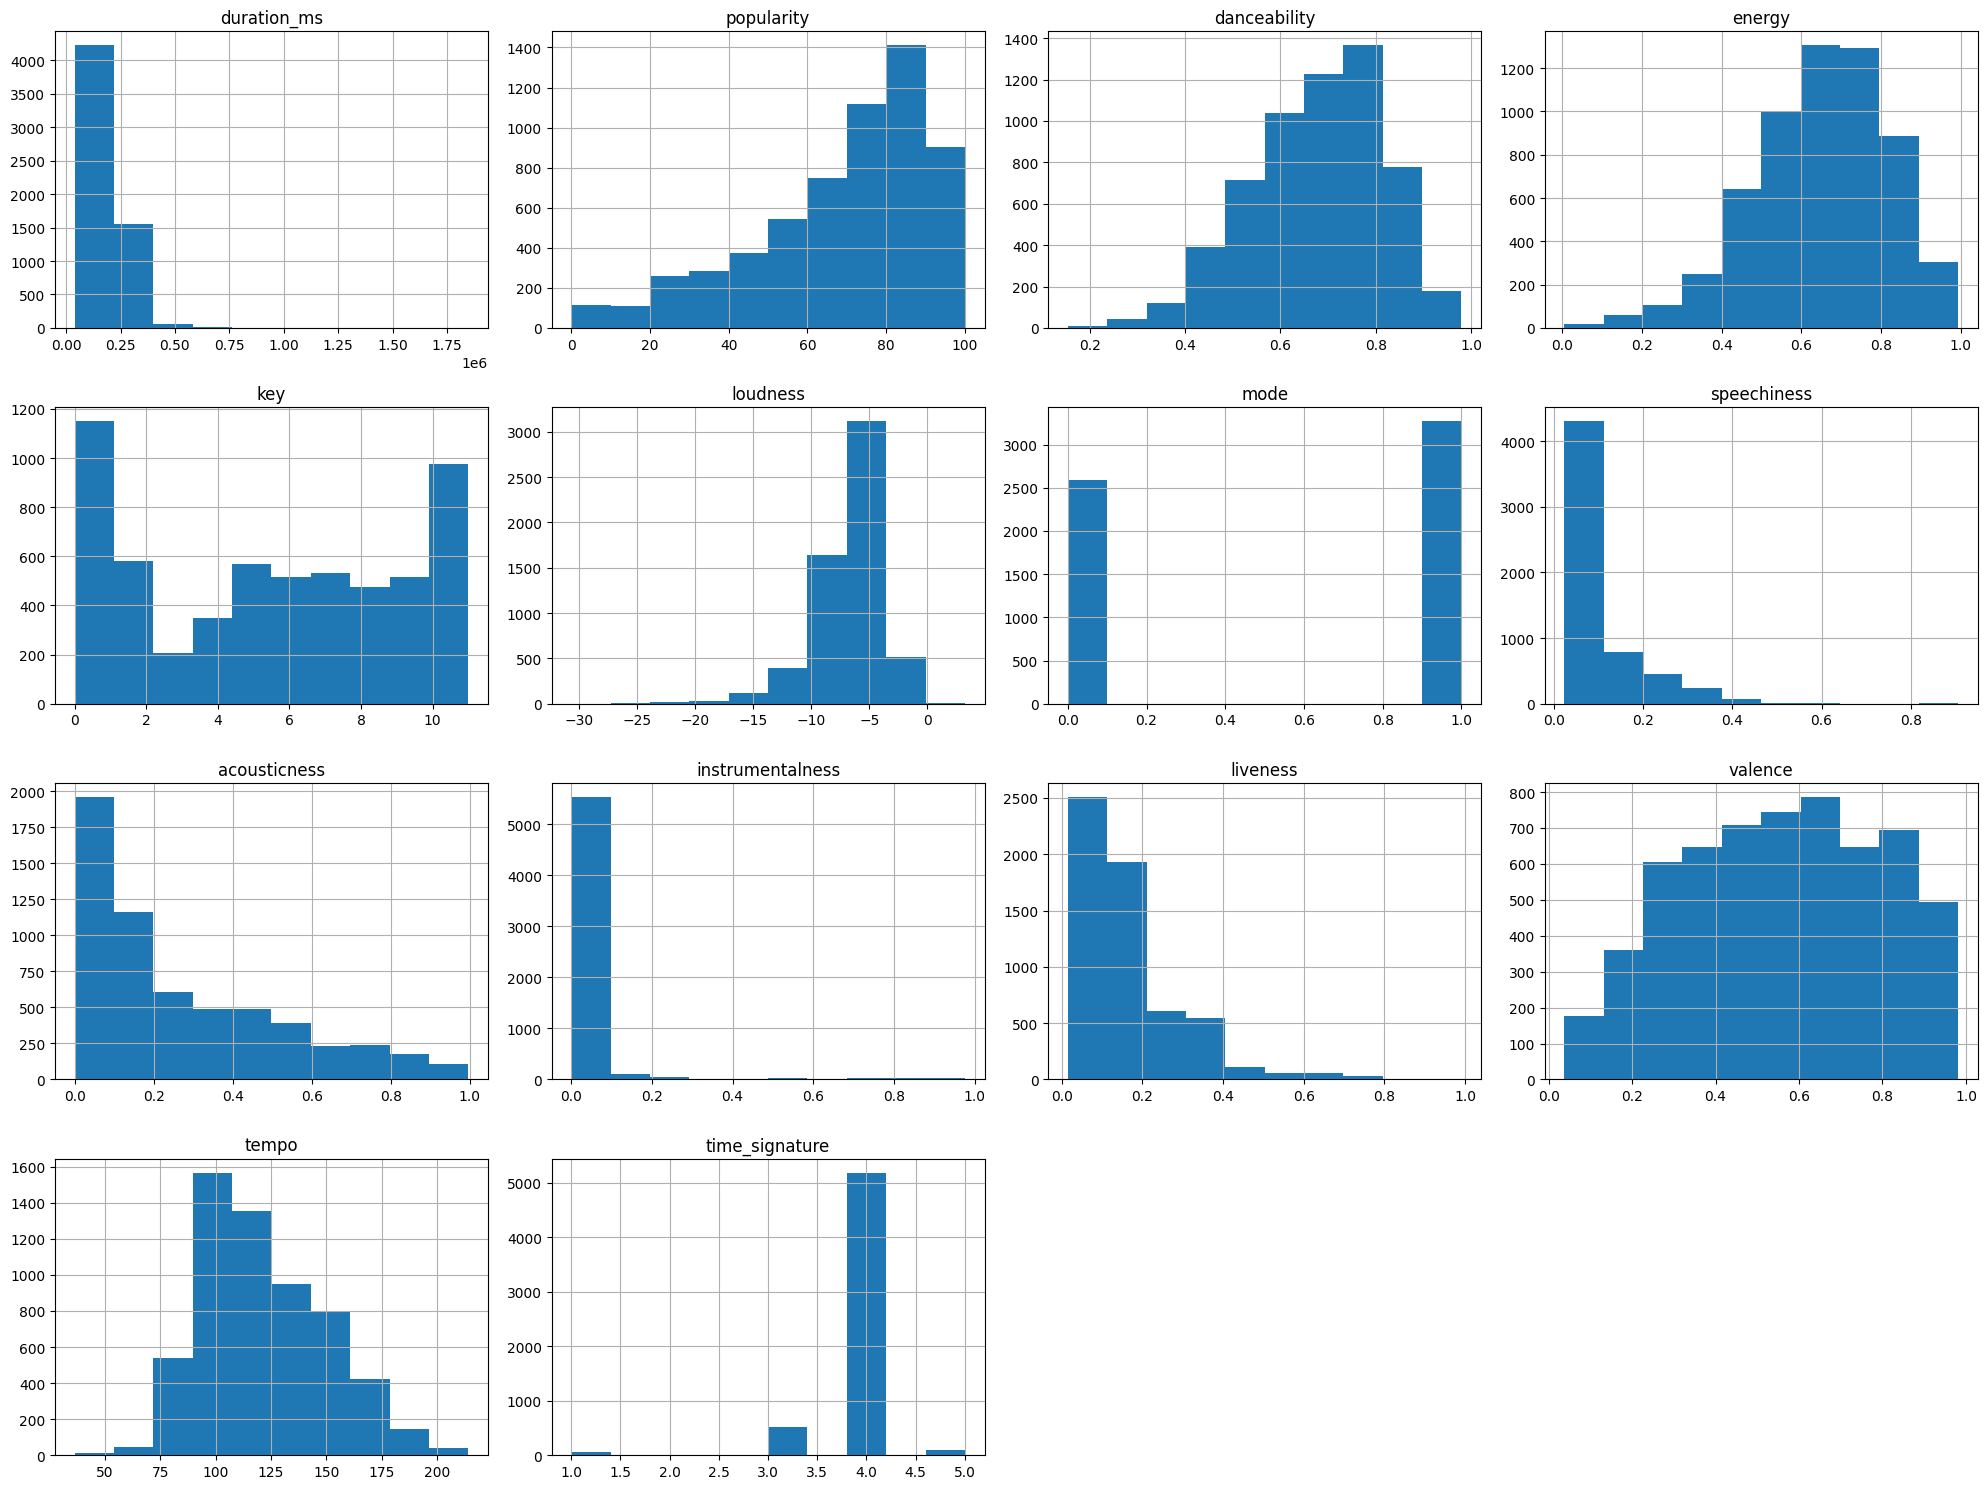

In [38]:
# Plot histograms for each column
music.hist(figsize=(20, 15))
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

#### 2. MODEL

In [39]:
# Feature columns
col_features = ['danceability',
                'acousticness',
                'energy',
                'instrumentalness',
                'liveness',
                'valence',
                'loudness',
                'speechiness',
                'tempo']

In [40]:
#Create labels

# log1p for liveness and instrumentalness
music['instrumentalness'] = np.log1p(music['instrumentalness'])
music['liveness'] = np.log1p(music['liveness'])

# Normalize features to the range [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(music[col_features])

# Perform clustering with KMeans
kmeans = KMeans(init="k-means++",
                n_clusters=4,
                max_iter=1000,
                random_state=42).fit(X)

# Add cluster labels to the DataFrame
music['cluster'] = kmeans.labels_

In [41]:
#save data sample

# Get the current directory
current_directory = os.getcwd()

# Get the directory of the parent directory of the current directory
parent_directory = os.path.dirname(current_directory)

# Specify the directory name to save the file
directory_name = "data_sample"

# Combine the parent directory with the directory name
directory_path = os.path.join(parent_directory, directory_name)

# Check if the directory exists, if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Specify the file name to save
file_name = "music.csv"

# Combine the directory with the file name
file_path = os.path.join(directory_path, file_name)

# Save the DataFrame as a CSV file
music.to_csv(file_path, index=False)

In [42]:
# target
y=music["cluster"]

In [43]:
# Train/Test
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)

In [44]:
target = pd.DataFrame({'mood':music['cluster'].tolist(),'encode':y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

mood  encode
0       0       0
44      1       1
102     2       2
98      3       3

In [45]:
""" # Define models
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()
xgb_model = XGBClassifier()

# Define parameter grids for grid search for each model
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 10],
    'min_child_weight': [1, 3, 5]
}

# Perform grid search for each model
rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, n_jobs=-1)
gb_grid = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, n_jobs=-1)
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, n_jobs=-1)

# Define the datasets X_train and y_train

# Perform grid search for each model
rf_grid_result = rf_grid.fit(X_train, y_train)
gb_grid_result = gb_grid.fit(X_train, y_train)
xgb_grid_result = xgb_grid.fit(X_train, y_train)

# Print results
print("Random Forest Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
print("Gradient Boosting Best: %f using %s" % (gb_grid_result.best_score_, gb_grid_result.best_params_))
print("XGBoost Best: %f using %s" % (xgb_grid_result.best_score_, xgb_grid_result.best_params_)) """

' # Define models\nrf_model = RandomForestClassifier()\ngb_model = GradientBoostingClassifier()\nxgb_model = XGBClassifier()\n\n# Define parameter grids for grid search for each model\nrf_param_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [3, 5, 10],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\ngb_param_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'learning_rate\': [0.01, 0.1, 0.5],\n    \'max_depth\': [3, 5, 10],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\nxgb_param_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'learning_rate\': [0.01, 0.1, 0.5],\n    \'max_depth\': [3, 5, 10],\n    \'min_child_weight\': [1, 3, 5]\n}\n\n# Perform grid search for each model\nrf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, n_jobs=-1)\ngb_grid = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, n_jobs=-1)\nxgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xg

XGBoost Best: 0.985284 using {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}

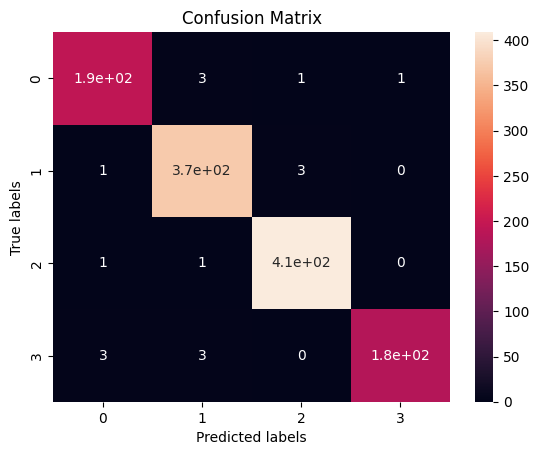

Accuracy Score: 0.9855072463768116


In [46]:
# Define the best hyperparameters
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}

# Create an instance of XGBClassifier with the best hyperparameters
best_model = XGBClassifier(**best_params)

# Train the model using the entire training dataset
best_model.fit(X_train, y_train)

# Predict the labels for the validation dataset
y_preds = best_model.predict(X_val)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_preds)

# Visualize the confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

# Set labels for the confusion matrix
labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Show the confusion matrix plot
plt.show()

# Compute and print the accuracy score
print("Accuracy Score:", accuracy_score(y_val, y_preds))

It seems like we have achieved a good model!

In [47]:
# Get the current directory
current_directory = os.getcwd()

# Get the directory of the parent directory of the current directory
parent_directory = os.path.dirname(current_directory)

# Specify the directory name to save the model file
directory_name = "model"

# Combine the parent directory with the directory name
directory_path = os.path.join(parent_directory, directory_name)

# Check if the directory exists, if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Specify the file name to save
file_name = "best_xgb_model.pkl"

# Combine the directory with the file name
file_path = os.path.join(directory_path, file_name)

# Save the model to the file
joblib.dump(best_model, file_path)

['c:\\Users\\Martín Ámez Segovia\\OneDrive\\Desktop\\MartinAmez_ML\\model\\best_xgb_model.pkl']

### PLAYLIST:

I'm going to create playlists by country, with 10 songs, to see examples of what I can do

In [51]:
music['mood'] = music['cluster'].apply(lambda x: 
                                        'Calm' if x == 1 else 
                                        ('Energetic' if x == 2 else 
                                        ('Happy' if x == 0 else 
                                        ('Sad' if x == 3 else None))))

In [68]:
# Happy playlist for Mexico
happy_pl_Mexico = music[(music["cluster"] == 0) & (music["country"] == "Mexico")].sort_values("popularity", ascending=False).head(10)[["artist", "album", "song_name"]]
happy_pl_Mexico

artist                                album       song_name
20         FloyyMenor                            Gata Only       Gata Only
2607          KAROL G  MAÑANA SERÁ BONITO (BICHOTA SEASON)           QLONA
3880      Oscar Ortiz                           FIRST LOVE      FIRST LOVE
2625           Maluma                             Don Juan     Según Quién
3870         Junior H                   $AD BOYZ 4 LIFE II         Y LLORO
3875             Xavi                          Poco A Poco     Poco A Poco
2676       Peso Pluma                         LA PEOPLE II    LA PEOPLE II
4787       Peso Pluma                       Rompe La Dompe  Rompe La Dompe
4795  Christian Nodal                         La Intención    La Intención
4790       Peso Pluma                              GÉNESIS       LA PEOPLE

In [67]:
# Calm playlist for France
calm_pl_France = music[(music["cluster"] == 1) & (music["country"] == "France")].sort_values("popularity", ascending=False).head(10)[["artist", "album", "song_name"]]
calm_pl_France

artist                                       album  \
357   Benson Boone                            Beautiful Things   
853    Teddy Swims  I've Tried Everything But Therapy (Part 1)   
1460      Ofenbach        Overdrive (feat. Norma Jean Martine)   
1476         CYRIL                                Stumblin' In   
3682           Sia                                  Gimme Love   
3372       Werenoi                                       Carré   
3663       Kerchak                                    Saison 2   
3666     Corneille   Avec classe (feat. Aya Nakamura & Trinix)   
3678       Tiakola                                           X   
3672     Disturbed          The Sound of Silence (CYRIL Remix)   

                                      song_name  
357                            Beautiful Things  
853                                Lose Control  
1460       Overdrive (feat. Norma Jean Martine)  
1476                               Stumblin' In  
3682                                 Gimme Love  
3372                                Chemin d'or  
3663                                   Saison 2  
3666  Avec classe (feat. Aya Nakamura & Trinix)  
3678                                          X  
3672         The Sound of Silence - CYRIL Remix

In [62]:
# Energetic playlist for India
energetic_pl_India = music[(music["cluster"] == 2) & (music["country"] == "India")].sort_values("popularity", ascending=False).head(10)[["artist", "album", "song_name"]]
energetic_pl_India

artist                                              album  \
2037           Shubh                                           One Love   
4100  Sai Abhyankkar                   Katchi Sera (From "Think Indie")   
2056          Raghav  Teri Baaton Mein Aisa Uljha Jiya Title Song (F...   
4109     Karan Aujla                                    Making Memories   
4123  Diljit Dosanjh                                          Hass Hass   
4116   Sachet Tandon                                       Malang Sajna   
4119  Diljit Dosanjh                                Naina (From "Crew")   
4127   Darshan Raval                                          Saajan Ve   
4118  Manan Bhardwaj                                             ANIMAL   
4128         Badshah                                        Ek Tha Raja   

                                              song_name  
2037                                           One Love  
4100                   Katchi Sera - From "Think Indie"  
2056  Teri Baaton Mein Aisa Uljha Jiya Title Song (F...  
4109                                             Softly  
4123                                          Hass Hass  
4116                                       Malang Sajna  
4119                                Naina (From "Crew")  
4127                                          Saajan Ve  
4118                                       Arjan Vailly  
4128                                              Daaku

In [72]:
# Sad playlist for Australia
sad_pl_Australia = music[(music["cluster"] == 3) & (music["country"] == "Australia")].sort_values("popularity", ascending=False).head(10)[["artist", "album", "song_name"]]
sad_pl_Australia

artist                    album  \
792                             SZA                   Saturn   
738                      Zach Bryan               Zach Bryan   
986                 Michael Marcagi          Scared To Start   
1265  Richy Mitch & The Coal Miners                     RMCM   
1030                     Zach Bryan  Something in the Orange   
1682                     Zach Bryan            Heading South   
1164                  Morgan Wallen      One Thing At A Time   
704                         Beyoncé            COWBOY CARTER   
1643                        Artemas                   pretty   
1693                     Lord Huron           Strange Trails   

                                          song_name  
792                                          Saturn  
738   I Remember Everything (feat. Kacey Musgraves)  
986                                 Scared To Start  
1265                                      Evergreen  
1030                        Something in the Orange  
1682                                  Heading South  
1164                                     Last Night  
704                                  TEXAS HOLD 'EM  
1643                          if u think i'm pretty  
1693                               The Night We Met

### FUN FACTS:

With this data, I can determine which countries have the most songs for each 'mood', so I can estimate the happiest or saddest countries, for example...

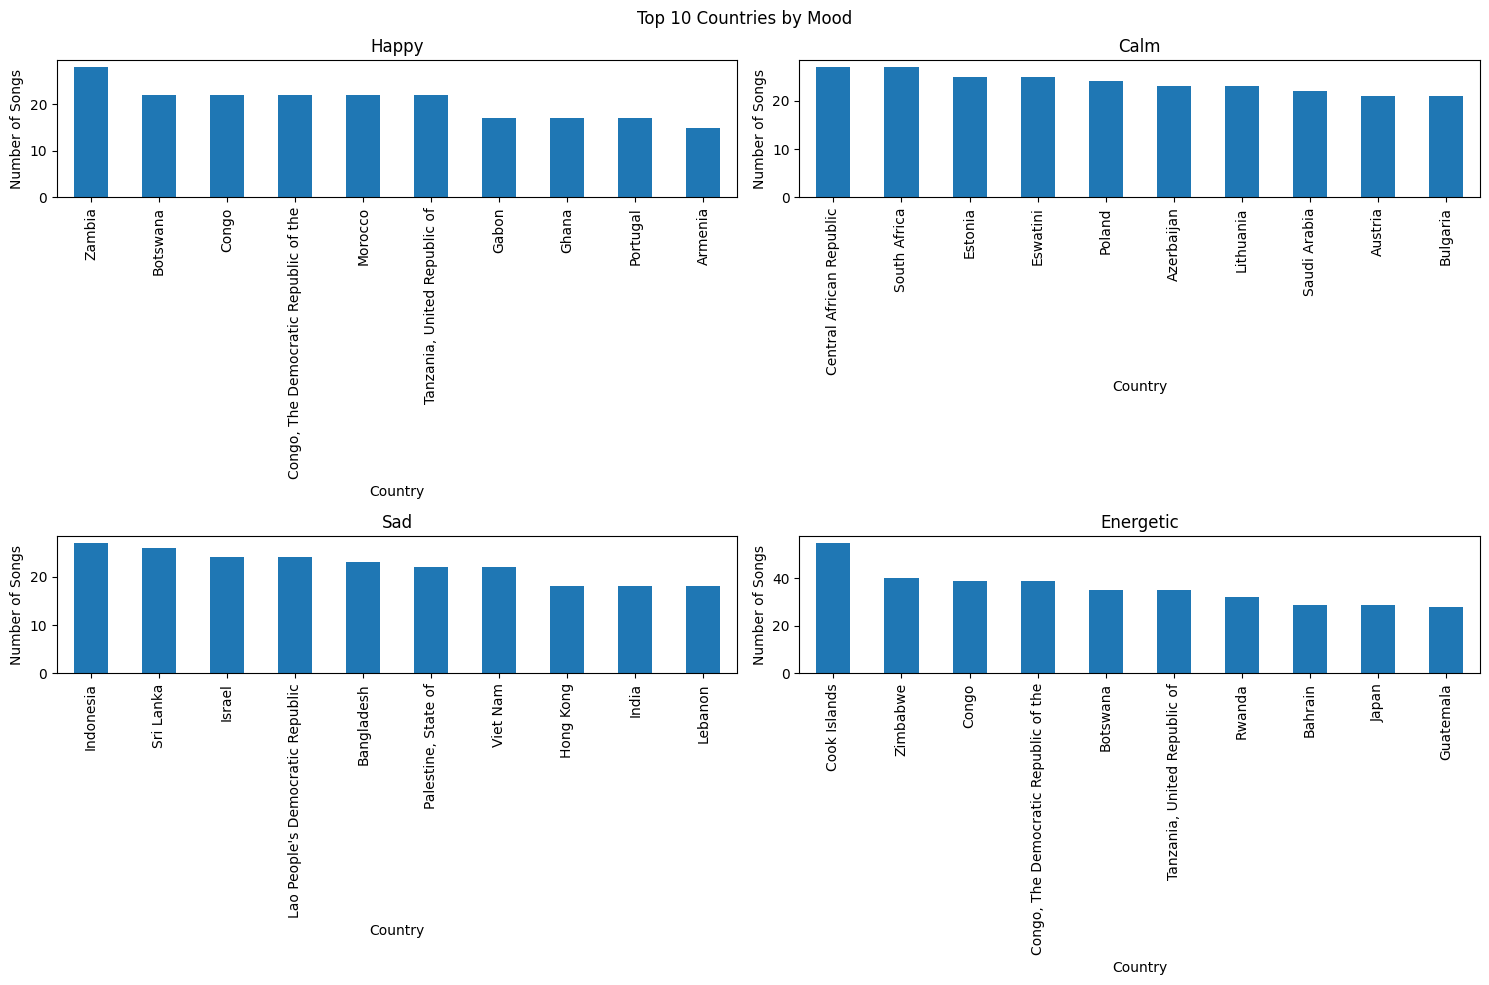

In [80]:
top_countries_by_mood = {}
n_largest = 10  # Cambia este valor según la cantidad de países que quieras mostrar

for mood in music['mood'].unique():
    top_countries_by_mood[mood] = music[music['mood'] == mood].groupby('country').size().nlargest(n_largest)

# Visualizar los resultados
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Top {} Countries by Mood'.format(n_largest))

for i, (mood, countries) in enumerate(top_countries_by_mood.items()):
    ax = axs[i // 2, i % 2]
    countries.plot(kind='bar', ax=ax)
    ax.set_title(mood)
    ax.set_xlabel('Country')
    ax.set_ylabel('Number of Songs')
    ax.set_xticklabels(countries.index, rotation=90)

plt.tight_layout()
plt.show()

Zambia the happiest country.
Central African Republic the calmest
Indonesia the saddest
And surprisingly Cook Islands, the country with the most energy!!

I can also analyze my recent listened songs and determine my mood... which is Happy! However, I don't show this last step